In [1]:
import pandas as pd
import geopandas as gpd

import networkx as nx
import osmnx as ox
from shapely.geometry import Point

from pyproj import Transformer
from shapely.geometry import box

In [2]:
gdf = gpd.read_file('data/pednet_ps.geojson')
gdf = gdf [['pednet_id', 'type','fclass','length','weighted_length_ug1','weighted_length_ug2','weighted_length_ug3','weighted_length_ug4','weighted_length_ug5','geometry']]
gdf.head()

,pednet_id,type,fclass,length,weighted_length_ug1,weighted_length_ug2,weighted_length_ug3,weighted_length_ug4,weighted_length_ug5,geometry
0,0,ped,crossing,8.945047,8.945047,8.945047,8.945047,8.945047,8.945047,"LINESTRING (1263866.756 229926.369, 1263861.28..."
1,1,ped,footway,16.675574,16.675574,16.675574,16.675574,16.675574,16.675574,"LINESTRING (1277978.83 238310.174, 1277966.394..."
2,2,ped,footway,458.294269,760.768486,905.131181,891.382353,884.507939,939.503251,"LINESTRING (1278374.334 238398.46, 1278317.326..."
3,3,ped,steps,17.555658,17.555658,17.555658,17.555658,17.555658,17.555658,"LINESTRING (1284223.335 235156.549, 1284211.29..."
4,4,ped,steps,79.474146,79.474146,79.474146,79.474146,79.474146,79.474146,"LINESTRING (1266761.001 234328.359, 1266840.43..."


In [3]:
# gdf.explore()

In [4]:
#Define the original bounding box coordinates in EPSG:4326 (WGS84)
minx, miny, maxx, maxy = -122.31095590105922, 47.6058824308882, -122.24154846437918, 47.62177699601234

# Create a bounding box as a GeoDataFrame with the original CRS
bbox = gpd.GeoDataFrame({'geometry': [box(minx, miny, maxx, maxy)]}, crs='EPSG:4326')

# Reproject the bounding box to CRS 2285
bbox_2285 = bbox.to_crs(epsg=2285)

# Get the reprojected bounding box coordinates
minx_2285, miny_2285, maxx_2285, maxy_2285 = bbox_2285.total_bounds

# Crop the data using the new bounding box in CRS 2285
gdf_2285 = gdf.to_crs(epsg=2285)  # Transform your original data to CRS 2285
gdf_cropped_2285 = gdf_2285.cx[minx_2285:maxx_2285, miny_2285:maxy_2285]

In [5]:
# gdf_cropped_2285.explore(tiles="cartodbpositron", style_kwds={'color': '#4C566A', 'opacity': 0})

In [ ]:
#reassign gdf
gdf = gdf_cropped_2285

In [6]:
nodes_dict = {}
node_list = []

# Create unique nodes and assign ids
for line in gdf.geometry:
    start_point, end_point = Point(line.coords[0]), Point(line.coords[-1])
    for point in [start_point, end_point]:
        point_id = (point.x, point.y)
        if point_id not in nodes_dict:
            nodes_dict[point_id] = len(nodes_dict)
            node_list.append({'x': point.x, 'y': point.y, 'osmid': nodes_dict[point_id]})

# Create nodes DataFrame
nodes_df = pd.DataFrame(node_list)
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.x, nodes_df.y))

# Create edges with correct MultiIndex including a key
edges_list = []
for idx, line in enumerate(gdf.geometry):
    start_point, end_point = Point(line.coords[0]), Point(line.coords[-1])
    start_id = nodes_dict[(start_point.x, start_point.y)]
    end_id = nodes_dict[(end_point.x, end_point.y)]
    edge_data = gdf.iloc[idx].drop('geometry').to_dict()
    edge_data['geometry'] = line
    edges_list.append((start_id, end_id, 0, edge_data))  # Add a default key of 0

# Create edges DataFrame with MultiIndex [u, v, key]
edges_df = pd.DataFrame(edges_list, columns=['u', 'v', 'key', 'data'])
edges_df.set_index(['u', 'v', 'key'], inplace=True)
edges_gdf = gpd.GeoDataFrame(edges_df['data'].tolist(), index=edges_df.index)

# Create graph from node and edge GeoDataFrames
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf, graph_attrs={'crs': 'epsg:2285'})

Both nodes are in the same weakly connected component.


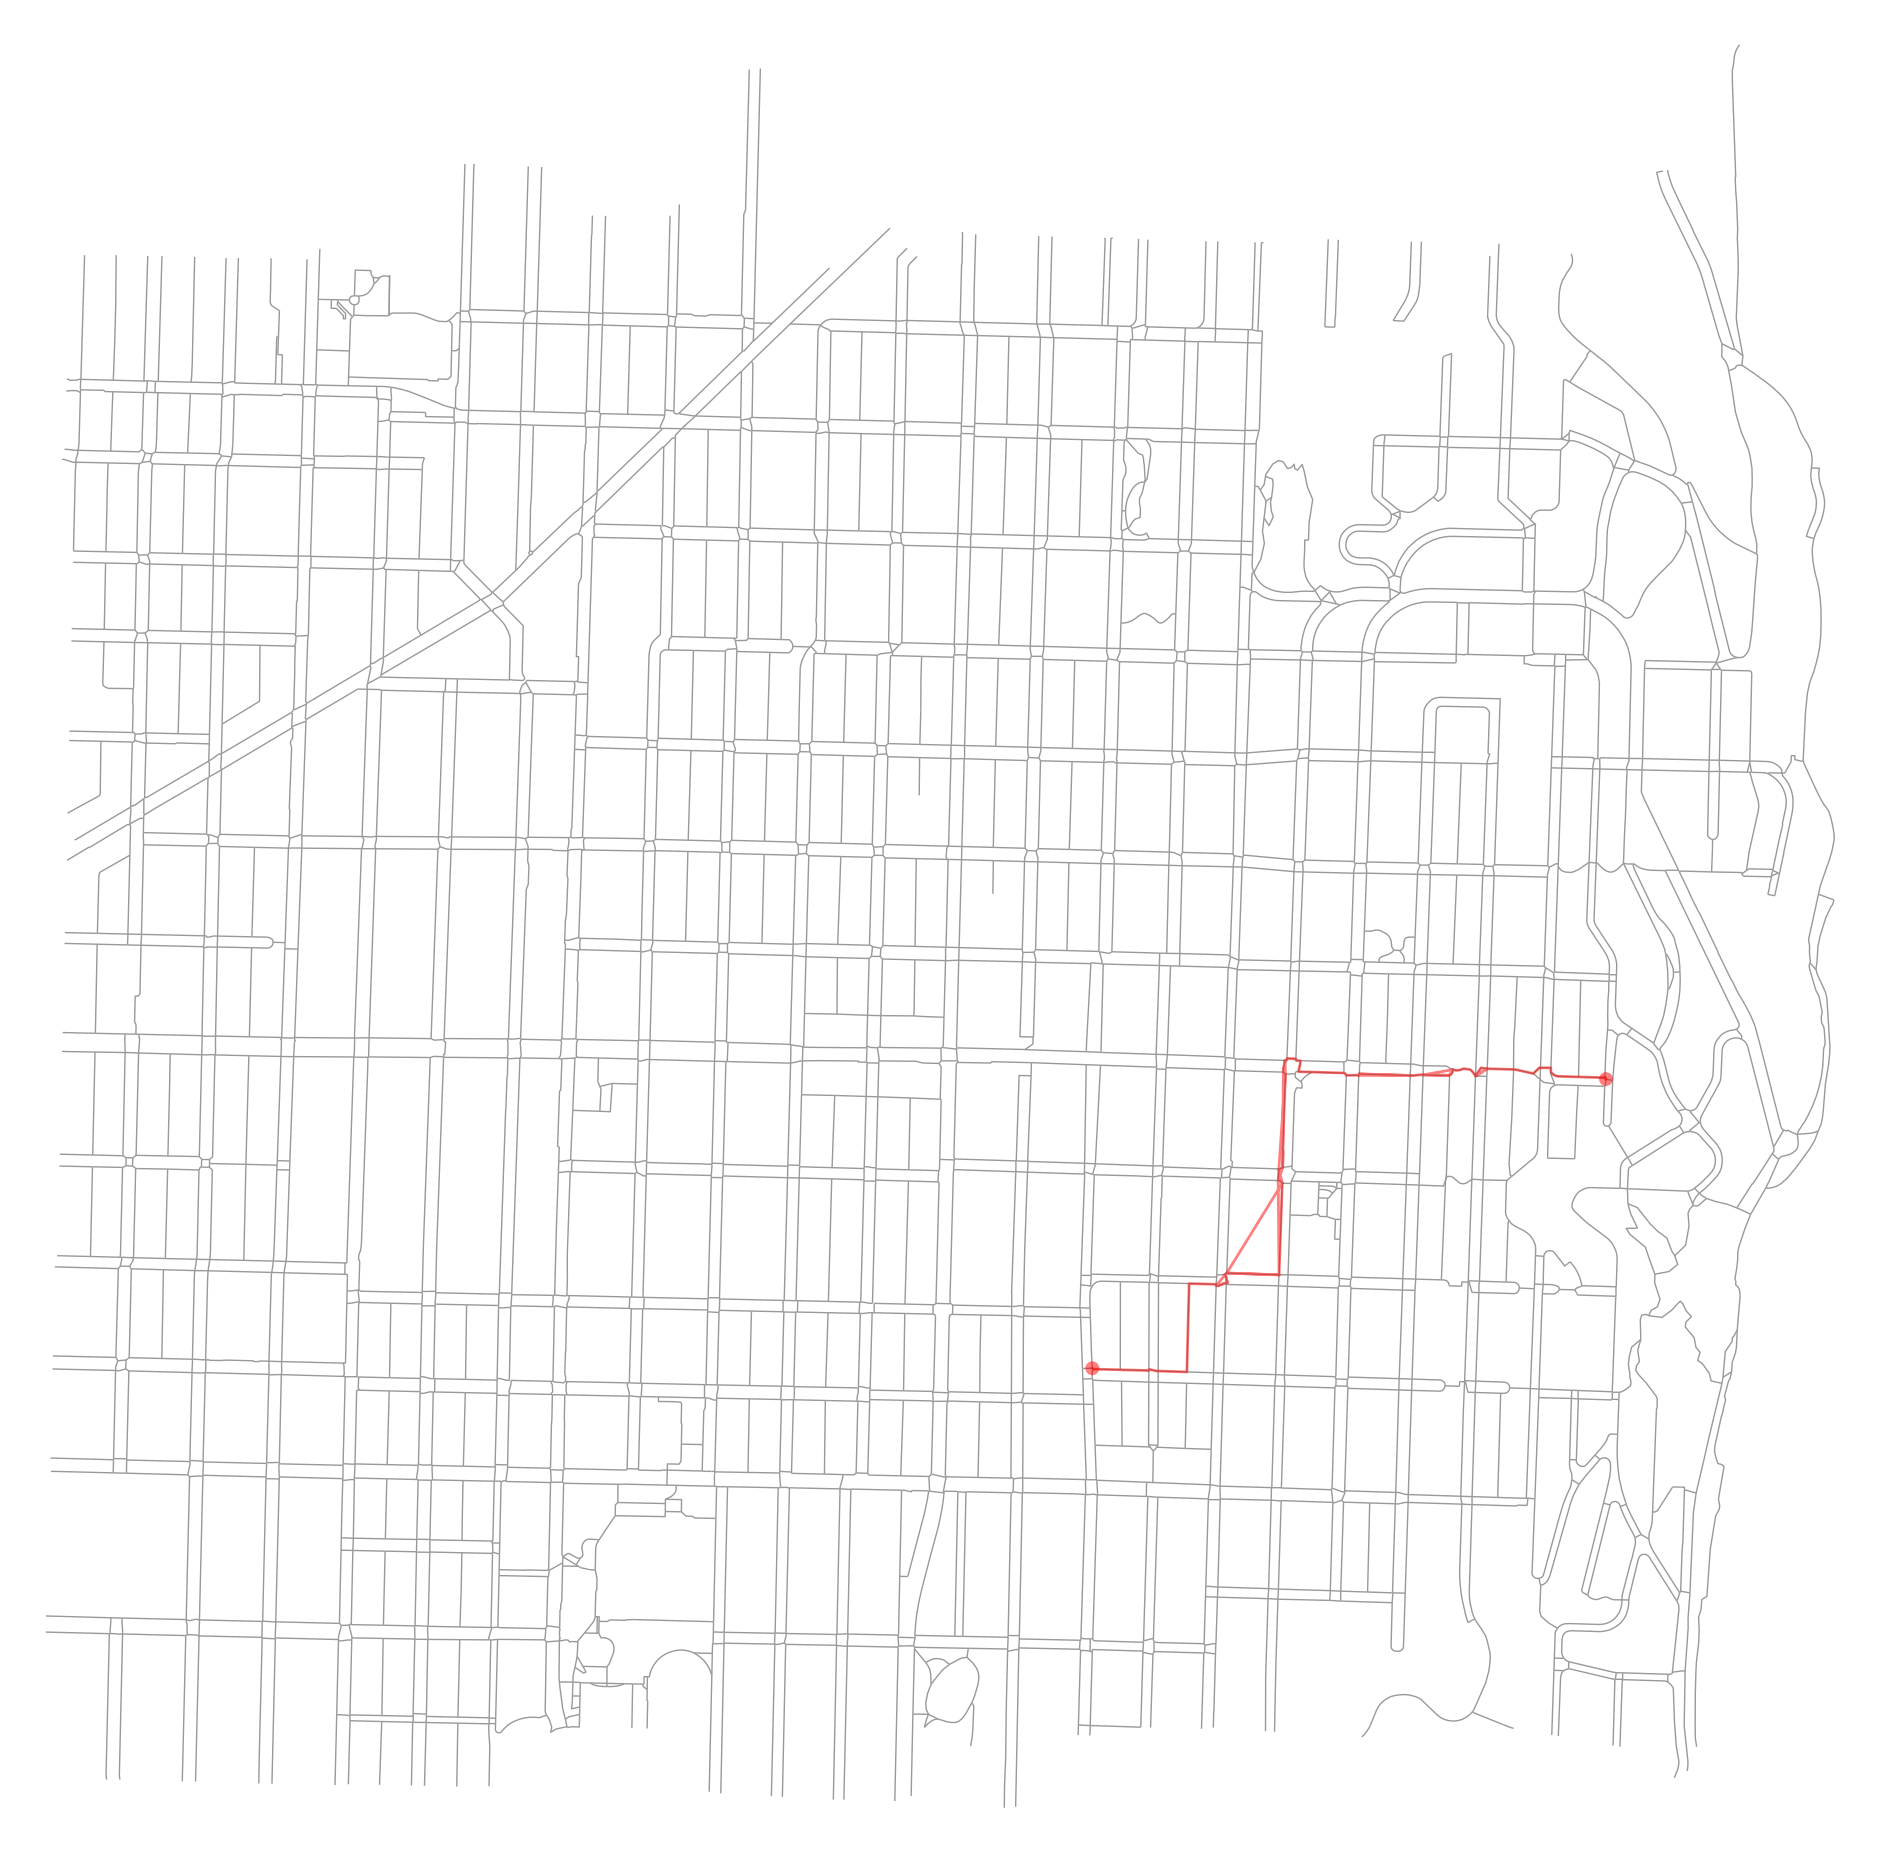

In [ ]:
# Step 1: Define origin and destination points and convert to CRS EPSG:2285
gdf_points = gpd.GeoDataFrame({'geometry': [Point(-122.28495496057349, 47.612805720063065), Point(-122.29372033716965, 47.609317847924004)]}, crs='EPSG:4326')
gdf_points = gdf_points.to_crs('EPSG:2285')

# Extract transformed coordinates
origin_point_transformed = gdf_points.iloc[0].geometry.coords[0]
destination_point_transformed = gdf_points.iloc[1].geometry.coords[0]

# Step 2: Find nearest nodes in the graph to the transformed points
origin_node = ox.distance.nearest_nodes(G, X=origin_point_transformed[0], Y=origin_point_transformed[1])
destination_node = ox.distance.nearest_nodes(G, X=destination_point_transformed[0], Y=destination_point_transformed[1])

# Step 3: Check for path connectivity
if nx.is_directed(G):
    weakly_components = list(nx.weakly_connected_components(G))
    if any(origin_node in comp and destination_node in comp for comp in weakly_components):
        print("Both nodes are in the same weakly connected component.")
    else:
        print("No path between the nodes: They are in different weakly connected components.")
else:
    print("The graph is undirected, use `nx.connected_components` instead.")

# Step 4: Convert to undirected graph and ensure edges have 'length' attribute
undirected_G = G.to_undirected()
for u, v, data in undirected_G.edges(data=True):
    if 'length' not in data:
        print(f"Edge ({u}, {v}) is missing 'length' attribute; setting to 0.")
        data['length'] = 0  # Assign a default value if necessary

# Step 5: Calculate shortest path and its total length
shortest_path = nx.shortest_path(undirected_G, source=origin_node, target=destination_node, weight='weighted_length_ug5')

# Step 6: Convert graph data to GeoDataFrames and reproject to EPSG:4326
try:
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(undirected_G)
    gdf_nodes = gdf_nodes.to_crs(epsg=4326)
    gdf_edges = gdf_edges.to_crs(epsg=4326)
except Exception as e:
    print(f"Error converting graph to GeoDataFrames or reprojecting: {e}")

# Step 7: Plot the graph with the shortest path highlighted
try:
    fig, ax = ox.plot_graph_route(undirected_G, shortest_path, route_linewidth=2, node_size=0, bgcolor='white', figsize=(24, 24))
except Exception as e:
    print(f"Error plotting the graph route: {e}")
